In [1]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

In [4]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('dataset')
IMAGES_DIR = 'images'
TRAIN_IMAGES_DIR = 'train/images'
VAL_IMAGES_DIR = 'val/images'
TEST_IMAGES_DIR = 'test/images'

# Labels directories
# LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = 'train/labels'
VAL_LABELS_DIR = 'val/labels'
TEST_LABELS_DIR = 'test/labels'

In [13]:
# Load train and test files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2})

# Preview the head of the train set
train.head()

Image_ID        class  confidence  ymin  xmin  ymax  xmax  \
0  id_u3q6jdck4j.jpg  Trophozoite         1.0   712  1241   737  1270   
1  id_a6cl90trri.jpg  Trophozoite         1.0   558  1566   600  1604   
2  id_qvc2le9sm8.jpg  Trophozoite         1.0  1317  2788  1448  2914   
3  id_w8xnbd5rvm.jpg  Trophozoite         1.0   925  1744  1041  1823   
4  id_6dop09rk02.jpg          NEG         1.0     0     0     0     0   

                 image_path  class_id  
0  images\id_u3q6jdck4j.jpg         0  
1  images\id_a6cl90trri.jpg         0  
2  images\id_qvc2le9sm8.jpg         0  
3  images\id_w8xnbd5rvm.jpg         0  
4  images\id_6dop09rk02.jpg         2

In [6]:
train.shape, test.shape

((23530, 9), (1178, 8))

In [11]:
train.columns

Index(['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax',
       'image_path', 'class_id'],
      dtype='object')

In [7]:
test.head()

Image_ID  class  confidence  ymin  xmin  ymax  xmax  \
0  id_5n9ov0rr22.jpg    NaN         NaN   NaN   NaN   NaN   NaN   
1  id_k6s11k3klo.jpg    NaN         NaN   NaN   NaN   NaN   NaN   
2  id_eftvcf9djb.jpg    NaN         NaN   NaN   NaN   NaN   NaN   
3  id_kc5tmoj1xa.jpg    NaN         NaN   NaN   NaN   NaN   NaN   
4  id_tirid4qt68.jpg    NaN         NaN   NaN   NaN   NaN   NaN   

                 image_path  
0  images\id_5n9ov0rr22.jpg  
1  images\id_k6s11k3klo.jpg  
2  images\id_eftvcf9djb.jpg  
3  images\id_kc5tmoj1xa.jpg  
4  images\id_tirid4qt68.jpg

In [14]:
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm

# Paths
train_csv = 'Train.csv'
images_dir = 'images/'
labels_dir = 'train/labels'

# Create labels directory if it doesn't exist
os.makedirs(labels_dir, exist_ok=True)

# Load the CSV
df = train


In [15]:
df.head()

Image_ID        class  confidence  ymin  xmin  ymax  xmax  \
0  id_u3q6jdck4j.jpg  Trophozoite         1.0   712  1241   737  1270   
1  id_a6cl90trri.jpg  Trophozoite         1.0   558  1566   600  1604   
2  id_qvc2le9sm8.jpg  Trophozoite         1.0  1317  2788  1448  2914   
3  id_w8xnbd5rvm.jpg  Trophozoite         1.0   925  1744  1041  1823   
4  id_6dop09rk02.jpg          NEG         1.0     0     0     0     0   

                 image_path  class_id  
0  images\id_u3q6jdck4j.jpg         0  
1  images\id_a6cl90trri.jpg         0  
2  images\id_qvc2le9sm8.jpg         0  
3  images\id_w8xnbd5rvm.jpg         0  
4  images\id_6dop09rk02.jpg         2

In [16]:
# Get the unique Image_IDs to track progress
image_ids = df['Image_ID'].unique()

# Iterate through each image with a progress bar
for image_id in tqdm(image_ids, desc="Processing images"):
    # Open the image to get dimensions
    image_path = os.path.join(images_dir, image_id)
    with Image.open(image_path) as img:
        width, height = img.size

    # Create a corresponding .txt file for each image
    label_file = os.path.join(labels_dir, image_id.replace('.jpg', '.txt'))
    with open(label_file, 'w') as f:
        # Extract all rows corresponding to the current image
        group = df[df['Image_ID'] == image_id]
        for _, row in group.iterrows():
            class_id = int(row['class_id'])
            ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

            # Convert to YOLO format
            x_center = ((xmin + xmax) / 2) / width
            y_center = ((ymin + ymax) / 2) / height
            bbox_width = (xmax - xmin) / width
            bbox_height = (ymax - ymin) / height

            # Write the line to the file
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

Processing images: 100%|██████████| 2747/2747 [01:44<00:00, 26.22it/s]


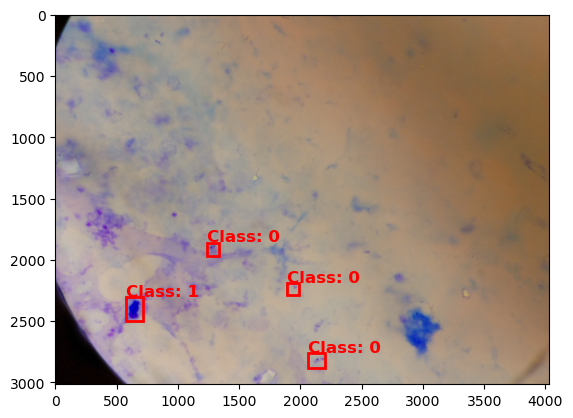

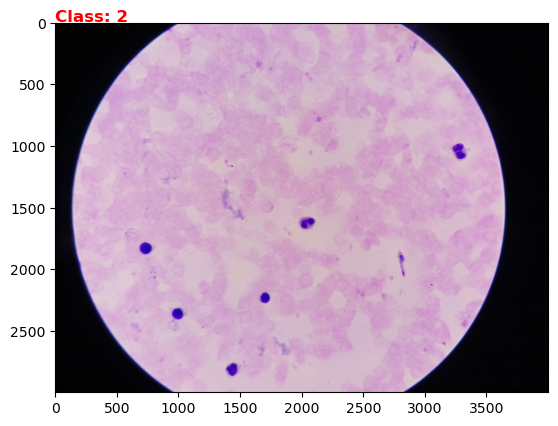

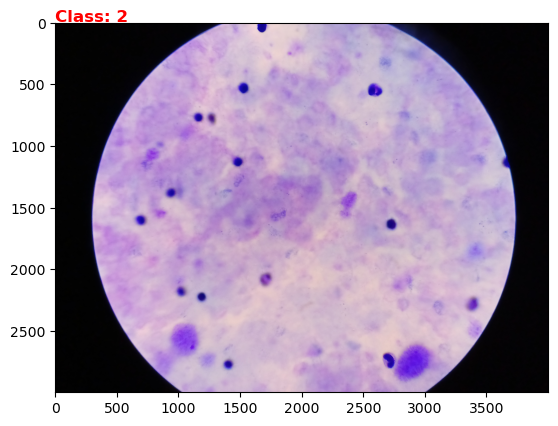

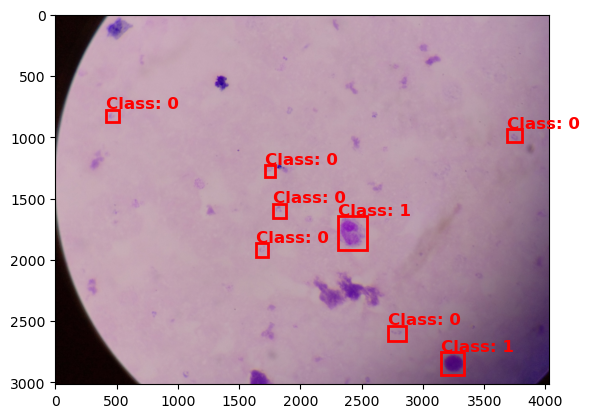

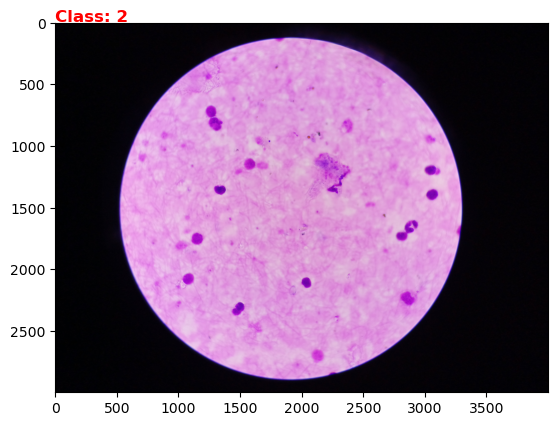

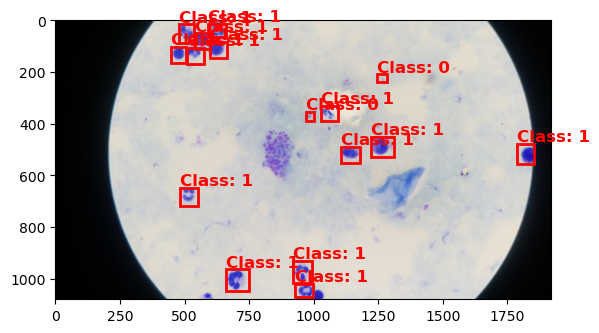

No label file found for id_02i83lum2m.jpg


In [21]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Define the paths to the images and labels
images_dir = 'images'
labels_dir = 'train/labels'

# Helper function to plot the image with bounding boxes
def plot_image_with_boxes(image_path, label_path):
    # Open the image
    image = Image.open(image_path)
    width, height = image.size

    # Create a Matplotlib figure
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Open the corresponding label file
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Iterate over each line in the label file
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

        # Convert YOLO format back to pixel coordinates
        xmin = (x_center - bbox_width / 2) * width
        ymin = (y_center - bbox_height / 2) * height
        xmax = (x_center + bbox_width / 2) * width
        ymax = (y_center + bbox_height / 2) * height

        # Draw the bounding box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 10, f"Class: {class_id}", color='red', fontsize=12, weight='bold')

    # Display the image
    plt.show()

# Automatically find the first 4 images and their corresponding label files
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])[:7]

# Plot each of the first 4 images
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    # Ensure the label file exists before plotting
    if os.path.exists(label_path):
        plot_image_with_boxes(image_path, label_path)
    else:
        print(f"No label file found for {image_file}")

In [22]:
os.listdir('images')[:4]

['id_0051lznyrt.jpg',
 'id_00m1onu6hj.jpg',
 'id_00n92f65ke.jpg',
 'id_00sirs797x.jpg']

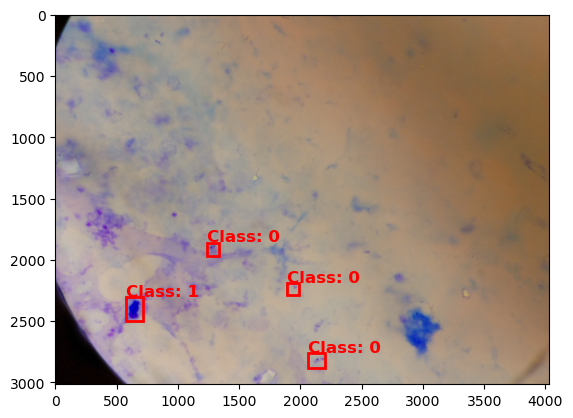

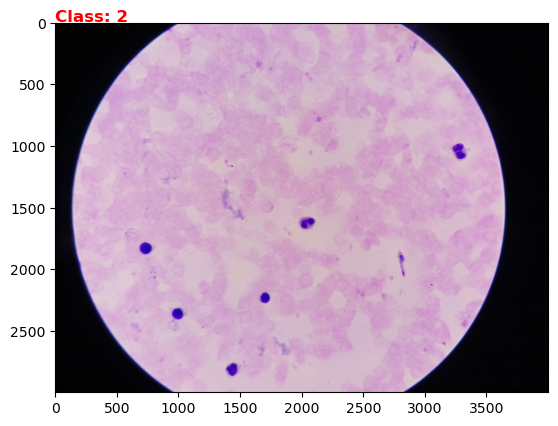

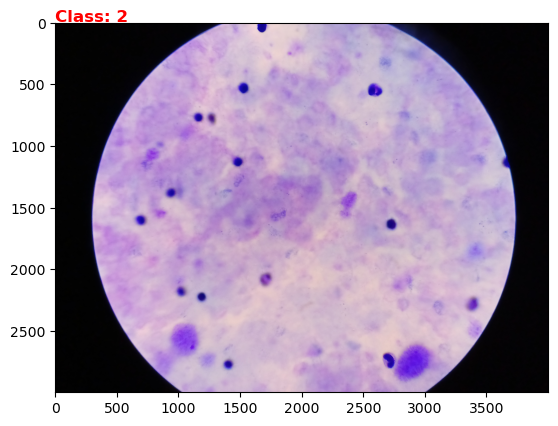

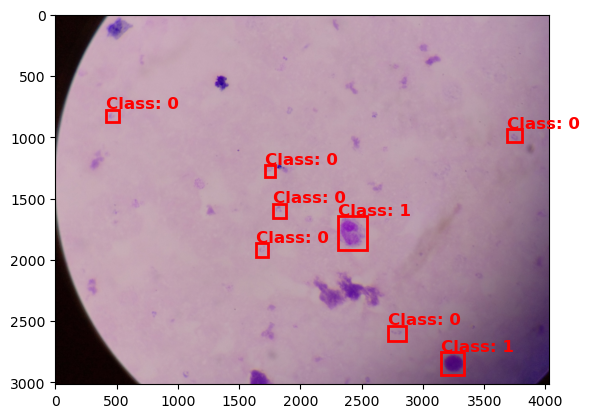

In [23]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd

# Define the paths to the images and CSV
images_dir = 'images'  # Update this path
# csv_file = 'path/to/Train.csv'  # Update this path

# Load the CSV data
# df = pd.read_csv(csv_file)

# Helper function to plot the image with bounding boxes from CSV labels
def plot_image_with_csv_boxes(image_path, csv_data):
    # Open the image
    image = Image.open(image_path)
    width, height = image.size

    # Create a Matplotlib figure
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Iterate over the bounding boxes in the CSV for this image
    for _, row in csv_data.iterrows():
        class_id = row['class_id']
        ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

        # Draw the bounding box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 10, f"Class: {class_id}", color='red', fontsize=12, weight='bold')

    # Display the image
    plt.show()

# Automatically find the first 4 images and their corresponding bounding boxes in the CSV
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])[:4]

# Plot each of the first 4 images
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)

    # Filter the CSV for this image
    csv_data = df[df['Image_ID'] == image_file]

    # Ensure there is data for this image in the CSV before plotting
    if not csv_data.empty:
        plot_image_with_csv_boxes(image_path, csv_data)
    else:
        print(f"No CSV data found for {image_file}")


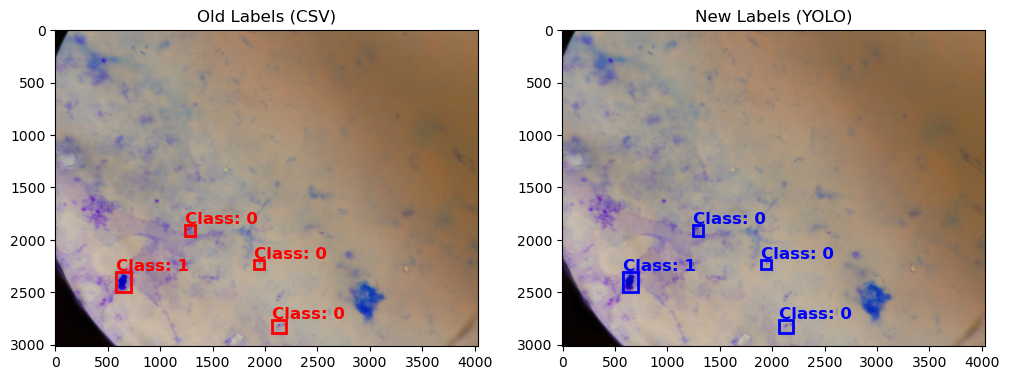

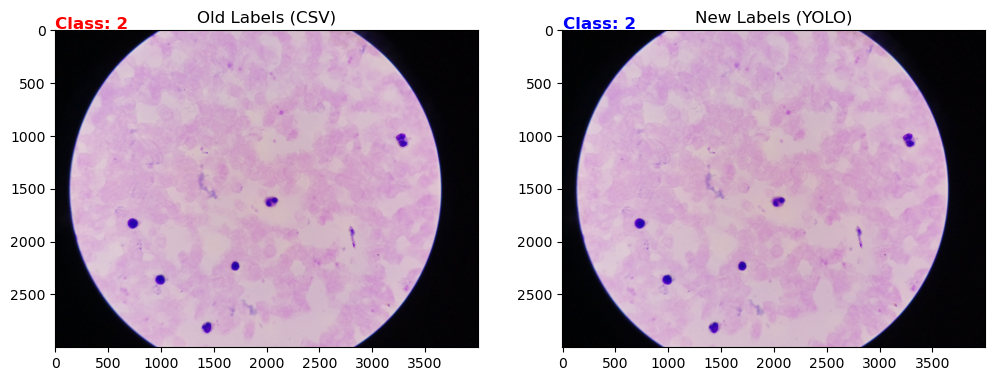

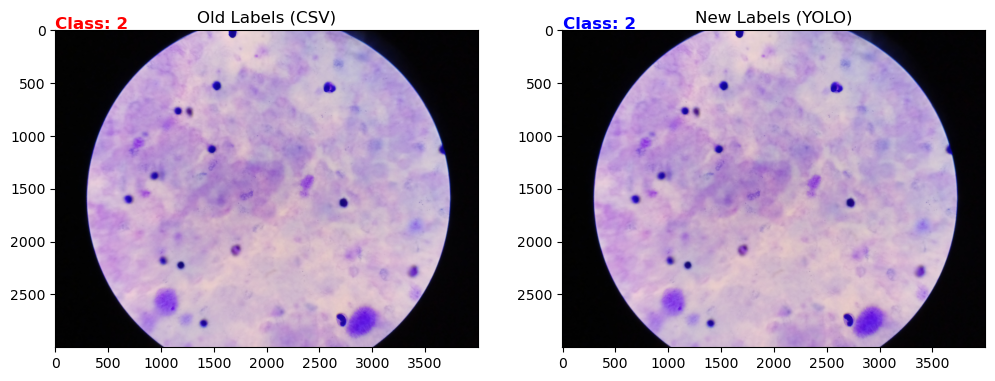

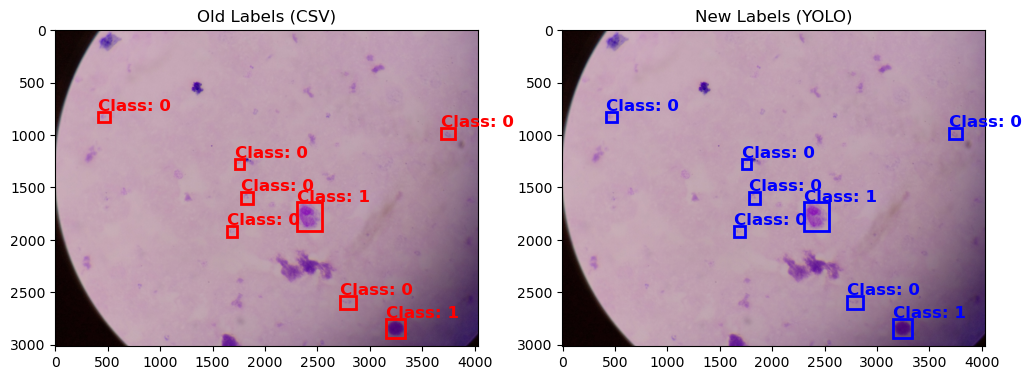

In [24]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd

# Define the paths to the images, CSV, and YOLO labels
images_dir = 'images'  # Update this path
# csv_file = 'path/to/Train.csv'  # Update this path
labels_dir = 'train/labels'  # Update this path

# Load the CSV data
# df = pd.read_csv(csv_file)

# Helper function to plot the image with bounding boxes from CSV labels
def plot_image_with_csv_boxes(ax, image, csv_data):
    width, height = image.size
    ax.imshow(image)

    # Iterate over the bounding boxes in the CSV for this image
    for _, row in csv_data.iterrows():
        class_id = row['class_id']
        ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

        # Draw the bounding box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 10, f"Class: {class_id}", color='red', fontsize=12, weight='bold')
    ax.set_title('Old Labels (CSV)')

# Helper function to plot the image with YOLO labels
def plot_image_with_yolo_boxes(ax, image, label_path):
    width, height = image.size
    ax.imshow(image)

    # Open the corresponding YOLO label file
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Iterate over each line in the label file
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

        # Convert YOLO format back to pixel coordinates
        xmin = (x_center - bbox_width / 2) * width
        ymin = (y_center - bbox_height / 2) * height
        xmax = (x_center + bbox_width / 2) * width
        ymax = (y_center + bbox_height / 2) * height

        # Draw the bounding box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 10, f"Class: {class_id}", color='blue', fontsize=12, weight='bold')
    ax.set_title('New Labels (YOLO)')

# Automatically find the first 4 images and their corresponding bounding boxes in the CSV and YOLO labels
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])[:4]

# Plot each of the first 4 images
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    # Filter the CSV for this image
    csv_data = df[df['Image_ID'] == image_file]

    # Ensure there is data for this image in both CSV and YOLO label file
    if not csv_data.empty and os.path.exists(label_path):
        # Open the image
        image = Image.open(image_path)

        # Create a figure with 2 subplots side by side
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the image with CSV labels on the left
        plot_image_with_csv_boxes(axs[0], image, csv_data)

        # Plot the image with YOLO labels on the right
        plot_image_with_yolo_boxes(axs[1], image, label_path)

        # Show the comparison
        plt.show()
    else:
        print(f"Missing data for {image_file}")


In [25]:
train.shape

(23530, 9)

In [34]:
len(os.listdir('train/labels'))

2747

In [28]:
train.columns

Index(['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax',
       'image_path', 'class_id'],
      dtype='object')

In [29]:
test.shape, test.columns

((1178, 8),
 Index(['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax',
        'image_path'],
       dtype='object'))

In [32]:
import os
import pandas as pd

# Paths
train_csv_path = 'Train.csv'  # Update with the correct path to the original Train.csv
labels_dir = 'train/labels'   # Update with the path to the YOLO labels folder

# Load the original Train.csv
train_df = pd.read_csv(train_csv_path)

# Get the list of image IDs that have corresponding YOLO label files
label_files = [f.replace('.txt', '') for f in os.listdir(labels_dir) if f.endswith('.txt')]

# Filter the original Train.csv to keep only rows corresponding to images in the label_files list
filtered_train_df = train_df[train_df['Image_ID'].str.replace('.jpg', '').isin(label_files)]

# Save the filtered DataFrame to a new CSV
filtered_train_csv_path = 'actual_train.csv'  # Update with the desired path for the new Train.csv
filtered_train_df.to_csv(filtered_train_csv_path, index=False)

print(f"Filtered Train.csv saved to: {filtered_train_csv_path}")


Filtered Train.csv saved to: actual_train.csv


C:\Users\SK\AppData\Local\Temp\ipykernel_11628\1705354916.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  filtered_train_df = train_df[train_df['Image_ID'].str.replace('.jpg', '').isin(label_files)]


In [40]:
import os
import pandas as pd

train_csv_path = 'Train.csv'  # Update with the correct path to the original Train.csv
labels_dir = 'train/labels'   # Update with the path to the YOLO labels folder


# Load the original Train.csv
train_df = pd.read_csv(train_csv_path)

# Get the list of image IDs that have corresponding YOLO label files
# We'll strip any extensions and ensure we compare IDs correctly
label_files = [os.path.splitext(f)[0] for f in os.listdir(labels_dir) if f.endswith('.txt')]

# Print the number of labels found for debug purposes
print(f"Found {len(label_files)} label files.")

# Ensure the Image_ID in the train DataFrame is comparable (without the '.jpg' extension)
train_df['Image_ID_no_ext'] = train_df['Image_ID'].str.replace('.jpg', '', regex=False)

# Filter the original Train.csv to keep only rows corresponding to images with YOLO labels
filtered_train_df = train_df[train_df['Image_ID_no_ext'].isin(label_files)]

# Print the size of the filtered DataFrame for debugging
print(f"Original Train.csv size: {train_df.shape}")
print(f"Filtered Train.csv size: {filtered_train_df.shape}")

# Drop the helper column used for filtering
filtered_train_df = filtered_train_df.drop(columns=['Image_ID_no_ext'])

# Save the filtered DataFrame to a new CSV
filtered_train_csv_path = 'new_filtered_Train.csv'  # Update with the desired path for the new Train.csv
filtered_train_df.to_csv(filtered_train_csv_path, index=False)

print(f"Filtered Train.csv saved to: {filtered_train_csv_path}")


Found 2747 label files.
Original Train.csv size: (23530, 8)
Filtered Train.csv size: (23530, 8)
Filtered Train.csv saved to: new_filtered_Train.csv


In [41]:

# Paths
train_csv_path = 'Train.csv'  # Update with the correct path to the original Train.csv
images_dir = 'images'   # Update with the path to the images folder
labels_dir = 'train/labels'
# Load the original Train.csv
train_df = pd.read_csv(train_csv_path)

# Get the list of image IDs that have corresponding image files in the images folder
available_images = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Get the list of image IDs that have corresponding YOLO label files
available_labels = [os.path.splitext(f)[0] for f in os.listdir(labels_dir) if f.endswith('.txt')]

# Find the intersection of both lists (images with both labels and image files)
valid_image_ids = set(available_images).intersection(available_labels)

# Print the number of valid image IDs for debugging
print(f"Found {len(valid_image_ids)} images with both files and labels.")

# Ensure the Image_ID in the train DataFrame is comparable (without the '.jpg' extension)
train_df['Image_ID_no_ext'] = train_df['Image_ID'].str.replace('.jpg', '', regex=False)

# Filter the original Train.csv to keep only rows corresponding to valid image IDs
filtered_train_df = train_df[train_df['Image_ID_no_ext'].isin(valid_image_ids)]

# Print the size of the filtered DataFrame for debugging
print(f"Original Train.csv size: {train_df.shape}")
print(f"Filtered Train.csv size: {filtered_train_df.shape}")

# Drop the helper column used for filtering
filtered_train_df = filtered_train_df.drop(columns=['Image_ID_no_ext'])

# Save the filtered DataFrame to a new CSV
filtered_train_csv_path = 'new_filtered_Train.csv'  # Update with the desired path for the new Train.csv
filtered_train_df.to_csv(filtered_train_csv_path, index=False)

print(f"Filtered Train.csv saved to: {filtered_train_csv_path}")

Found 2747 images with both files and labels.
Original Train.csv size: (23530, 8)
Filtered Train.csv size: (23530, 8)
Filtered Train.csv saved to: new_filtered_Train.csv


In [42]:
import os
import pandas as pd

# Paths
train_csv_path = 'Train.csv'  # Correct path to the original Train.csv
images_dir = 'images'   # Correct path to the images folder
labels_dir = 'train/labels'   # Correct path to the YOLO labels folder

# Load the original Train.csv
train_df = pd.read_csv(train_csv_path)

# List available images and labels
available_images = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')]
available_labels = [os.path.splitext(f)[0] for f in os.listdir(labels_dir) if f.endswith('.txt')]

# Intersection of images with labels
valid_image_ids = set(available_images).intersection(available_labels)

# Debugging outputs
print(f"Found {len(valid_image_ids)} images with both files and labels.")
print(f"Sample image IDs: {list(valid_image_ids)[:5]}")

# Adjust Image_ID in DataFrame for comparison
train_df['Image_ID_no_ext'] = train_df['Image_ID'].str.replace('.jpg', '', regex=False)

# Filter DataFrame based on valid image IDs
filtered_train_df = train_df[train_df['Image_ID_no_ext'].isin(valid_image_ids)]

# Debugging sizes
print(f"Original Train.csv size: {train_df.shape}")
print(f"Filtered Train.csv size: {filtered_train_df.shape}")

# Debug sample IDs from train_df for comparison
print(f"Sample Image_ID_no_ext: {train_df['Image_ID_no_ext'].head()}")

# Save the filtered DataFrame
filtered_train_csv_path = 'new_filtered_Train.csv'
filtered_train_df.to_csv(filtered_train_csv_path, index=False)
print(f"Filtered Train.csv saved to: {filtered_train_csv_path}")


Found 2747 images with both files and labels.
Sample image IDs: ['id_nmtvik0q7s', 'id_d7gkp4j3jr', 'id_13s4p0geo0', 'id_cx3fedu308', 'id_anwoop5gmd']
Original Train.csv size: (23530, 8)
Filtered Train.csv size: (23530, 8)
Sample Image_ID_no_ext: 0    id_u3q6jdck4j
1    id_a6cl90trri
2    id_qvc2le9sm8
3    id_w8xnbd5rvm
4    id_6dop09rk02
Name: Image_ID_no_ext, dtype: object
Filtered Train.csv saved to: new_filtered_Train.csv


In [57]:
train['Image_ID'].value_counts()[:15]

id_mzq1jmom69.jpg    92
id_tmtzoe9bns.jpg    85
id_7tgo99b7gy.jpg    74
id_1xpbtfb4xh.jpg    74
id_n5talfnmmk.jpg    73
id_bu04j7jxbr.jpg    72
id_15rb0dgq66.jpg    70
id_wd51nh9072.jpg    68
id_ugc3d0uqrm.jpg    66
id_k061rd9uty.jpg    64
id_i0sssks1lo.jpg    64
id_5bbz3srksa.jpg    63
id_d9km9wq3gf.jpg    62
id_tbop9cccoc.jpg    62
id_2phbgf1x5m.jpg    60
Name: Image_ID, dtype: int64

In [50]:
test['Image_ID'].value_counts()

id_5n9ov0rr22.jpg    1
id_3tctoq9fo0.jpg    1
id_10bpnyj4yo.jpg    1
id_6ttmu9eh7o.jpg    1
id_eeluv2nmp7.jpg    1
                    ..
id_3su13btien.jpg    1
id_npy4q47cg3.jpg    1
id_lh8oi3cp68.jpg    1
id_h19lsvl87z.jpg    1
id_kw30dj6ngz.jpg    1
Name: Image_ID, Length: 1178, dtype: int64

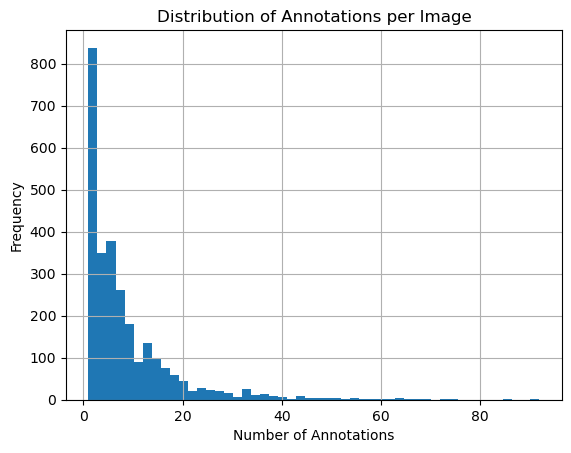

In [51]:
import matplotlib.pyplot as plt

# Plot distribution of annotations per image
train['Image_ID'].value_counts().hist(bins=50)
plt.title("Distribution of Annotations per Image")
plt.xlabel("Number of Annotations")
plt.ylabel("Frequency")
plt.show()


In [54]:
train.to_csv('train_classid.csv', index=False)

In [55]:
import os
import pandas as pd
from PIL import Image

# Paths
train_csv_path = 'train_classid.csv'  # Path to your Train.csv file
images_dir = 'images'         # Path to the images directory
labels_dir = 'train/labels'   # Path to the labels directory where .txt files will be saved

# Load the Train.csv data
train_df = pd.read_csv(train_csv_path)

# Ensure the labels directory exists
os.makedirs(labels_dir, exist_ok=True)

# Function to convert and save YOLO labels
def save_yolo_labels(df, image_dir, labels_dir):
    # Group the annotations by Image_ID
    grouped = df.groupby('Image_ID')

    for image_id, group in grouped:
        # Get the image path and image dimensions
        image_path = os.path.join(image_dir, image_id)
        
        # Get image size
        try:
            with Image.open(image_path) as img:
                img_width, img_height = img.size
        except FileNotFoundError:
            print(f"Image {image_id} not found in {image_dir}, skipping...")
            continue
        
        # Open the corresponding .txt file for writing
        label_file_path = os.path.join(labels_dir, image_id.replace('.jpg', '.txt'))
        with open(label_file_path, 'w') as f:
            # Write each bounding box for the image
            for _, row in group.iterrows():
                # Convert to YOLO format
                class_id = int(row['class_id'])  # Assumes class_id is already mapped
                x_center = ((row['xmin'] + row['xmax']) / 2) / img_width
                y_center = ((row['ymin'] + row['ymax']) / 2) / img_height
                width = (row['xmax'] - row['xmin']) / img_width
                height = (row['ymax'] - row['ymin']) / img_height
                
                # Write the annotation to the file
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Run the conversion function
save_yolo_labels(train_df, images_dir, labels_dir)

print("YOLO label files have been generated.")


YOLO label files have been generated.


In [58]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# Paths
train_csv_path = 'train_classid.csv'  # Path to the Train.csv file
test_csv_path = 'Test.csv'    # Path to the Test.csv file
images_dir = 'images'         # Path to the directory containing all images
train_images_dir = 'train/images'  # Directory to save train images
test_images_dir = 'test/images'    # Directory to save test images

# Create directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)

# Load the Train.csv and Test.csv files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Move train images with progress bar
print("Moving train images...")
for image_id in tqdm(train_df['Image_ID'].unique(), desc="Train Images"):
    src_path = os.path.join(images_dir, image_id)
    dst_path = os.path.join(train_images_dir, image_id)
    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)
    else:
        print(f"Image {image_id} not found in {images_dir}, skipping...")

# Move test images with progress bar
print("Moving test images...")
for image_id in tqdm(test_df['Image_ID'].unique(), desc="Test Images"):
    src_path = os.path.join(images_dir, image_id)
    dst_path = os.path.join(test_images_dir, image_id)
    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)
    else:
        print(f"Image {image_id} not found in {images_dir}, skipping...")

print("Images have been moved to their respective folders.")


Moving train images...


Train Images: 100%|██████████| 2747/2747 [00:03<00:00, 884.75it/s] 


Moving test images...


Test Images: 100%|██████████| 1178/1178 [00:01<00:00, 666.37it/s]

Images have been moved to their respective folders.


Class distribution in the dataset:
Trophozoite    15838
WBC             7004
NEG              688
Name: class, dtype: int64


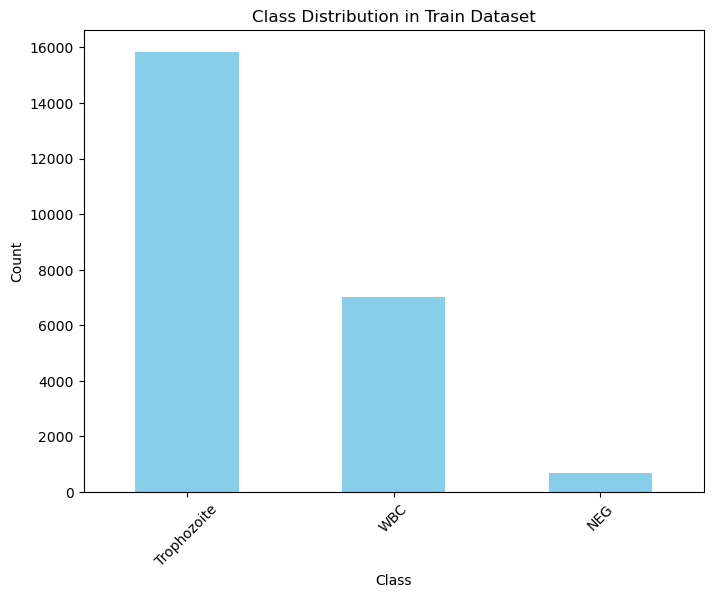

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Train.csv file
train_csv_path = 'train_classid.csv'  # Update with the correct path to the Train.csv file
train_df = pd.read_csv(train_csv_path)

# Count occurrences of each class
class_counts = train_df['class'].value_counts()

# Print the class counts
print("Class distribution in the dataset:")
print(class_counts)

# Plot the class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Train Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [62]:
from PIL import Image
import os

image_sizes = []

# Loop through images and get dimensions
for image_id in tqdm(train_df['Image_ID'].unique()):
    image_path = os.path.join('train/images', image_id)
    try:
        with Image.open(image_path) as img:
            image_sizes.append(img.size)  # (width, height)
    except FileNotFoundError:
        print(f"Image {image_id} not found.")

# Convert to DataFrame to summarize
sizes_df = pd.DataFrame(image_sizes, columns=['width', 'height'])

# Display summary statistics for image sizes
print(sizes_df.describe())


100%|██████████| 2747/2747 [00:23<00:00, 116.63it/s]

             width       height
count  2747.000000  2747.000000
mean   3310.200218  2356.039316
std    1011.254633   927.908711
min    1920.000000  1080.000000
25%    1920.000000  1080.000000
50%    4000.000000  3000.000000
75%    4032.000000  3016.000000
max    4160.000000  3120.000000


In [63]:
missing_images = []
for image_id in train_df['Image_ID'].unique():
    image_path = os.path.join('train/images', image_id)
    if not os.path.exists(image_path):
        missing_images.append(image_id)

if missing_images:
    print(f"Missing images: {len(missing_images)}")
else:
    print("No missing images.")

No missing images.
